In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# ------------------------------
# 1) Load
# ------------------------------
df = pd.read_csv("credit_risk_1000.csv")
print("Shape:", df.shape)
print(df.head())

# ------------------------------
# 2) Basic cleaning
# ------------------------------
df = df.drop_duplicates()

if "id" in df.columns:
    df = df.drop(columns=["id"])

df["target"] = df["target"].astype(int)

print("\nClass distribution (full data):")
print(df["target"].value_counts())
print("Default rate:", df["target"].mean())


#Feature Engineering means creating new features or modifying existing ones to
#  improve the performance of machine learning models. It invlolves transforming raw data into 
# meaningful features that capture relevant information for the predictive task at hand.

#try to create features



# ------------------------------
# 3) Simple Feature Engineering (easy to teach)
# ------------------------------
# ratios (very important in credit risk)
df["debt_to_income"] = df["total_debt"] / df["income"].replace(0, np.nan)
df["loan_to_income"] = df["loan_amount"] / df["income"].replace(0, np.nan)

# simple EMI proxy (not exact EMI, but good teaching feature)
df["emi_proxy"] = (df["loan_amount"] * df["interest_rate"]) / 1200.0
df["emi_to_income"] = df["emi_proxy"] / (df["income"] / 12.0)

# a simple flag feature
df["high_dti_flag"] = (df["debt_to_income"] > 0.60).astype(int)

# handle inf
df = df.replace([np.inf, -np.inf], np.nan)


Shape: (1000, 11)
   id  age   income  employment_years  loan_amount  interest_rate  \
0   1   59   762306               5.5       314483           14.2   
1   2   49  2035390              12.4        83642           12.5   
2   3   35  1049523               1.7       394920           15.4   
3   4   63   543299               6.0       166659           15.7   
4   5   28  1258455               5.1       150172           14.5   

   credit_score  total_debt home_ownership loan_purpose  target  
0           668       35903           Rent          Car       0  
1           699      361587           Rent     Personal       0  
2           583       97953            Own         Home       0  
3           715       66075           Rent     Personal       0  
4           628      190612       Mortgage         Home       0  

Class distribution (full data):
target
0    848
1    152
Name: count, dtype: int64
Default rate: 0.152


In [ ]:
# always remember that we dont keep correlated features in the model because they create multicollinearity issues

# for example weather in celsius and fahrenheit are correlated features would tell same thing amnd model will get confused
# corelation range is -1 to +1 

# ------------------------------
# 5) Feature reduction Part A: Remove highly correlated numeric features (X vs X)
#    Idea: if two features are too correlated (>0.75), drop one
# ------------------------------
X_only = df.drop(columns=["target"])
X_num = X_only.select_dtypes(include=[np.number])

corr_matrix = X_num.corr().abs() #this gives absolute correlation values absolute means ignore sign

# take upper triangle only (avoid duplicates)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop_corr = []
threshold_corr = 0.75

for col in upper.columns:
    if any(upper[col] > threshold_corr):
        to_drop_corr.append(col)

print("\nHighly correlated numeric columns to drop (threshold=0.75):")
print(to_drop_corr)

df = df.drop(columns=to_drop_corr, errors="ignore")





Highly correlated numeric columns to drop (threshold=0.75):
['emi_proxy', 'emi_to_income']


In [ ]:
corr_matrix

,age,income,employment_years,loan_amount,interest_rate,credit_score,total_debt,debt_to_income,loan_to_income,emi_proxy,emi_to_income,high_dti_flag
age,1.000000,0.000931,0.749248,0.066690,0.010335,0.039919,0.004333,0.005540,0.064341,0.067831,0.069980,0.002944
income,0.000931,1.000000,0.002117,0.003404,0.024741,0.022735,0.587322,0.058777,0.478630,0.012154,0.447042,0.027700
employment_years,0.749248,0.002117,1.000000,0.066594,0.001590,0.013349,0.022069,0.011808,0.060913,0.060330,0.053783,0.017672
loan_amount,0.066690,0.003404,0.066594,1.000000,0.034111,0.007637,0.001992,0.012751,0.689209,0.930260,0.679243,0.069324
interest_rate,0.010335,0.024741,0.001590,0.034111,1.000000,0.000258,0.001974,0.008431,0.006752,0.331780,0.238175,0.021642
credit_score,0.039919,0.022735,0.013349,0.007637,0.000258,1.000000,0.028044,0.020352,0.034419,0.002906,0.028688,0.001058
total_debt,0.004333,0.587322,0.022069,0.001992,0.001974,0.028044,1.000000,0.732729,0.271239,0.010494,0.249143,0.353655
debt_to_income,0.005540,0.058777,0.011808,0.012751,0.008431,0.020352,0.732729,1.000000,0.003155,0.022369,0.003731,0.585971
loan_to_income,0.064341,0.478630,0.060913,0.689209,0.006752,0.034419,0.271239,0.003155,1.000000,0.629261,0.952847,0.070006
emi_proxy,0.067831,0.012154,0.060330,0.930260,0.331780,0.002906,0.010494,0.022369,0.629261,1.000000,0.717046,0.072800


In [27]:
# ------------------------------
# 6) Feature reduction Part B: VIF (numeric only)
#    VIF checks multicollinearity vs ALL other features
# ------------------------------

#VIF OF A FEATURE IS HOW WELL IT IS EXPLAINED BY ALL OTHER FEATURES IN THE DATASET

#VIF STANDS FOR VARIANCE INFLATION FACTOR #IT TELLS THE OVERALL MULTICOLLINEARITY OF A FEATURE WITH RESPECT TO ALL OTHER FEATURES IN THE DATASET
# VIF internally fits a regression model for each feature as a function of all other features and calculates 
# how much the variance of the estimated regression coefficient is increased due to multicollinearity.
#for example we start withn age ...based upon other features we try to predict age if age can be predicted well from other features
# the based upon R2 value we calculate VIF ....   vif - 1/(1-R2)...

X_only = df.drop(columns=["target"])
X_num = X_only.select_dtypes(include=[np.number]).copy()

# simple missing fill for VIF calc
X_num = X_num.fillna(X_num.median())

# add constant
X_num_const = sm.add_constant(X_num) #constant is needed for VIF calculation because it represents the intercept term in regression models else the VIF calculation may be incorrect or misleading. 
                                    #without a constant term, the regression model may not accurately capture the relationships between the independent variables, leading to incorrect VIF values.

vif_df = pd.DataFrame()
vif_df["feature"] = X_num_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_num_const.values, i) for i in range(X_num_const.shape[1])]

vif_df = vif_df.sort_values("VIF", ascending=False)
print("\nVIF table (top high VIF first):")
print(vif_df.head(15))

# simple rule: drop features with VIF > 10 (except const)
vif_drop = vif_df[(vif_df["VIF"] > 10) & (vif_df["feature"] != "const")]["feature"].tolist()
print("\nVIF-based columns to drop (VIF > 10):")
print(vif_drop)

df = df.drop(columns=vif_drop, errors="ignore")  
 #this cell drops columns with high VIF values from the dataframe by removing multicollinear features to improve model stability and interpretability. 
#diffeence between VIF and correlation is that correlation measures the linear relationship between two variables, while VIF assesses how much the variance of a regression coefficient is inflated due to multicollinearity among multiple independent variables.
# diffrence betweeen VIF and corelation matrix is that correlation matrix shows the pairwise relationships between variables, while VIF assesses the impact of multicollinearity on regression coefficients.


VIF table (top high VIF first):
             feature         VIF
0              const  188.949414
7         total_debt    6.142912
8     debt_to_income    4.882758
2             income    3.624974
9     loan_to_income    3.417101
4        loan_amount    2.637079
1                age    2.289078
3   employment_years    2.288515
10     high_dti_flag    1.568271
6       credit_score    1.004649
5      interest_rate    1.003530

VIF-based columns to drop (VIF > 10):
[]


In [28]:
# ------------------------------
# 7) Train/Test split (IMPORTANT: split before balancing)
# ------------------------------
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain class distribution (original):")
print(y_train.value_counts())
print("Test class distribution (original):")
print(y_test.value_counts())




Train class distribution (original):
target
0    678
1    122
Name: count, dtype: int64
Test class distribution (original):
target
0    170
1     30
Name: count, dtype: int64


In [33]:
# ------------------------------
# 8) Create TRAIN dataframe for balancing
# ------------------------------
train_df = X_train.copy()
train_df["target"] = y_train

df_good = train_df[train_df["target"] == 0]
df_bad  = train_df[train_df["target"] == 1]

print("\nTrain Good:", len(df_good), "Train Bad:", len(df_bad))


Train Good: 678 Train Bad: 122


In [30]:
# ------------------------------
# 9) UPSAMPLING (duplicate minority class)
# ------------------------------
df_bad_up = df_bad.sample(n=len(df_good), replace=True, random_state=42)
train_up = pd.concat([df_good, df_bad_up]).sample(frac=1, random_state=42)

print("\nAfter UPSAMPLING train distribution:")
print(train_up["target"].value_counts())






After UPSAMPLING train distribution:
target
0    678
1    678
Name: count, dtype: int64


In [ ]:
#majority class minority class..this is called class imbalance problem
#downsampling major drawback is we lose data from majority class
#upsampling drawback is we overfit on minority class because we are duplicating data points
#this is class balancing. 99% of the time we do upsampling for minority class because in credit risk we want to catch all defaulters
#downsampling can be considered when the dataset is extremely large, and computational efficiency is a concern 
# also variabilty in majority class is very less

In [31]:
# ------------------------------
# 10) DOWNSAMPLING (reduce majority class)
# ------------------------------
df_good_down = df_good.sample(n=len(df_bad), random_state=42)
train_down = pd.concat([df_good_down, df_bad]).sample(frac=1, random_state=42)

print("\nAfter DOWNSAMPLING train distribution:")
print(train_down["target"].value_counts())


After DOWNSAMPLING train distribution:
target
0    122
1    122
Name: count, dtype: int64


In [11]:
# 11) Preprocessing + Logistic (One-Hot Encoding happens here)
# ------------------------------
# numeric vs categorical columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

model = LogisticRegression(max_iter=1000)  # keep simple for teaching

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", model)
])

In [12]:
# ------------------------------
# 12) Choose which balanced data to train on
#     Set MODE = "up" or "down" or "none"
# ------------------------------
MODE = "up"   # change to "down" or "none"

if MODE == "up":
    X_train_final = train_up.drop(columns=["target"])
    y_train_final = train_up["target"]
elif MODE == "down":
    X_train_final = train_down.drop(columns=["target"])
    y_train_final = train_down["target"]
else:
    X_train_final = X_train
    y_train_final = y_train

print("\nTraining mode:", MODE)
print("Train size:", X_train_final.shape, "Test size:", X_test.shape)


Training mode: up
Train size: (1356, 12) Test size: (200, 12)


In [13]:

# ------------------------------
# 13) Train model
# ------------------------------
pipe.fit(X_train_final, y_train_final)


# ------------------------------
# 14) Predict probabilities on test
# ------------------------------
proba = pipe.predict_proba(X_test)[:, 1]
print("\nTest AUC:", round(roc_auc_score(y_test, proba), 4))



Test AUC: 0.8073


c:\Users\Kunal Mahajan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

results = []   # empty list to store rows

cutoffs = [0.20, 0.25, 0.30, 0.35, 0.40, 0.50,.55, 0.60, 0.65, 0.70]

for t in cutoffs:
    pred = (proba >= t).astype(int)

    precision = precision_score(y_test, pred, zero_division=0)
    recall = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)



    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

    results.append({
        "Cutoff": t,
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1_Score": round(f1, 3),
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

# Convert list to DataFrame
cutoff_df = pd.DataFrame(results)

print("\nCutoff-wise performance summary:")
print(cutoff_df)



Cutoff-wise performance summary:
   Cutoff  Precision  Recall  F1_Score  TP   FP  FN   TN
0    0.20      0.204   0.933     0.335  28  109   2   61
1    0.25      0.215   0.867     0.344  26   95   4   75
2    0.30      0.245   0.867     0.382  26   80   4   90
3    0.35      0.258   0.833     0.394  25   72   5   98
4    0.40      0.271   0.767     0.400  23   62   7  108
5    0.50      0.333   0.633     0.437  19   38  11  132
6    0.55      0.388   0.633     0.481  19   30  11  140
7    0.60      0.400   0.533     0.457  16   24  14  146
8    0.65      0.429   0.500     0.462  15   20  15  150
9    0.70      0.438   0.467     0.452  14   18  16  152


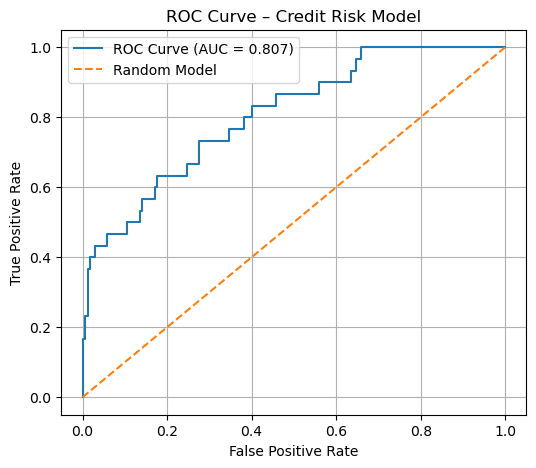

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ------------------------------
# 1) Calculate ROC values
# ------------------------------
fpr, tpr, thresholds = roc_curve(y_test, proba)

# ------------------------------
# 2) Calculate AUC
# ------------------------------
auc_score = roc_auc_score(y_test, proba)

# ------------------------------
# 3) Plot ROC curve
# ------------------------------
plt.figure(figsize=(6, 5))

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Model")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Credit Risk Model")
plt.legend()
plt.grid(True)

plt.show()

#roc curve is a graphical representation that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
#  AUC represents the degree or measure of separability achieved by the model; it indicates how well the model can distinguish between the positive and negative classes.

In [34]:
print(auc_score)

0.8072549019607843


In [35]:

# ------------------------------
# 16) Save full-data PD scores (optional)
# ------------------------------
full_proba = pipe.predict_proba(X)[:, 1]
out = X.copy()
out["pd_score"] = full_proba
out.to_csv("pd_scores_full.csv", index=False)
print("\nSaved: pd_scores_full.csv")


Saved: pd_scores_full.csv
